## Variable engineering

 The aim of this challenge is to predict the future numbers of restaurant visitors. This makes it a Time Series Forecasting problem. The data was collected from Japanese restaurants. We have chosen this project, because the data set is small and easily accessible.<br>
 The project is very important and interesting for us because it is a real data set, and real business problem.


In this section, we create new variables.Change their types.Check the relevance of each variable for the future model.<br>
let's try!!!

## Load libraries
\\( P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)} \\)

In [84]:
import numpy as np #It provides a high-performance multidimensional array object, and tools for working with these arrays
import pandas as pd #
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

## Data Wrangling

The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

In [85]:
# Data Aggregation
airres = pd.read_csv('../input/air_reserve.csv')
airstore = pd.read_csv('../input/air_store_info.csv')
hpgres = pd.read_csv('../input/hpg_reserve.csv')
hpgstore = pd.read_csv('../input/hpg_store_info.csv')
airvisit = pd.read_csv('../input/air_visit_data.csv')
dates = pd.read_csv('../input/date_info.csv')
wd = pd.read_csv('../input/WeatherData.csv')
rel = pd.read_csv('../input/store_id_relation.csv')
test = pd.read_csv('../input/sample_submission.csv')

In [86]:
def HTML_with_style(df, style=None, random_id=None):
    from IPython.display import HTML # import HTML
    import numpy as np
    import re

    df_html = df.to_html() #get at the html pandas puts out via the to_html method.

    if random_id is None:
        #generate a random identifier for the html table and style that going to create
        random_id = 'id%d' % np.random.choice(np.arange(1000000)) 
    if style is None:
        style = """
        <style>
            table#{random_id} {{color: blue}}
        </style>
        """.format(random_id=random_id)
    else:
        new_style = []
        s = re.sub(r'</?style>', '', style).strip()
        for line in s.split('\n'):
                line = line.strip()
                if not re.match(r'^table', line):
                    line = re.sub(r'^', 'table ', line)
                new_style.append(line)
        new_style = ['<style>'] + new_style + ['</style>']

        style = re.sub(r'table(#\S+)?', 'table#%s' % random_id, '\n'.join(new_style))

    df_html = re.sub(r'<table', r'<table id=%s ' % random_id, df_html)

    return HTML(style + df_html)
#print(HTML(airvisit.head(1)))


In [87]:
airvisit.tail(1)

,air_store_id,visit_date,visitors
252107,air_24e8414b9b07decb,2017-04-22,5


In [88]:
airres.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1


In [89]:
hpgres.head(1)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1


  ## Convert the date format and group by date reservation data.

We want to group reservation data from AIR and HPG by date on which registration was made.As we predict the total number of visitors at a particular time in a particular restaurant.We also calculate the time interval between the date of the order and the date of the visit of the restaurant.

In [90]:
#AIR
######## COPY ######
#airres = pd.read_csv('../input/air_reserve.csv')
#copyAirRes = airres.copy()

vdt = pd.to_datetime(airres.visit_datetime)
rdt = pd.to_datetime(airres.reserve_datetime)
airres['visit_date']=vdt.dt.date
airres['rd']=rdt.dt.date

In [91]:
airres.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,rd
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01


In [92]:
airstore[airstore['air_store_id']=='air_877f79706adbfb06']

,air_store_id,air_genre_name,air_area_name,latitude,longitude
707,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [93]:
airres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 6 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
visit_date          92378 non-null object
rd                  92378 non-null object
dtypes: int64(1), object(5)
memory usage: 4.2+ MB


In [94]:
airres['res_date_diff'] = airres.apply(lambda r: (r['visit_date'] - r['rd']).days, axis=1)

In [95]:

# BY DAYS
medianDiff= airres.groupby(['air_store_id','visit_date'], as_index=False)['res_date_diff'].median() # by days
sumDiff = airres.groupby(['air_store_id','visit_date'], as_index=False)['res_date_diff'].sum() # by days


# By Visitors
sumVisitors = airres.groupby(['air_store_id','visit_date'], as_index=False)['reserve_visitors'].sum()




#print(len(sumDiff.unique()))
#print(len(medianDiff.unique()))
#airres = airres.groupby(['air_store_id','visit_date'], as_index=False)\
#[['reserve_visitors']].sum()#.rename(columns={'visit_datetime':'visit_date'})

In [96]:
#medianDiff.tail(10)
print("All the days that in median diff is :",len(medianDiff['visit_date'].unique()))
print("All the days that in sum diff is :",len(sumDiff['visit_date'].unique()))
print("All the Resturants that in air reserve  :",len(airres['air_store_id'].unique()))
print("All the days that in air reserve  :",len(airres['visit_date'].unique()))
print("All the days that in VISITORS :",len(sumVisitors['visit_date'].unique()))
print(433*314)

#type(medianDiff)

All the days that in median diff is : 433
All the days that in sum diff is : 433
All the Resturants that in air reserve  : 314
All the days that in air reserve  : 433
All the days that in VISITORS : 433
135962


In [97]:
sumDiff.tail(10)

,air_store_id,visit_date,res_date_diff
29820,air_fea5dc9594450608,2017-04-15,10
29821,air_fea5dc9594450608,2017-04-18,6
29822,air_fea5dc9594450608,2017-04-19,0
29823,air_fea5dc9594450608,2017-04-20,3
29824,air_fea5dc9594450608,2017-04-21,29
29825,air_fea5dc9594450608,2017-04-22,0
29826,air_fea5dc9594450608,2017-04-25,9
29827,air_fea5dc9594450608,2017-04-28,29
29828,air_fea5dc9594450608,2017-05-20,34
29829,air_fee8dcf4d619598e,2017-01-09,16


In [98]:
sumVisitors.head(2)
#airres = pd.merge(medianDiff,how='left')

,air_store_id,visit_date,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9


In [99]:
# MERGE MEDIAN (diff date) and SUM(visitors reserve)
sumVisitors = pd.merge(sumVisitors,medianDiff,how='left',on=['air_store_id','visit_date'])

In [100]:
sumVisitors.head(10)

,air_store_id,visit_date,reserve_visitors,res_date_diff
0,air_00a91d42b08b08d9,2016-10-31,2,0.0
1,air_00a91d42b08b08d9,2016-12-05,9,4.0
2,air_00a91d42b08b08d9,2016-12-14,18,6.0
3,air_00a91d42b08b08d9,2016-12-17,2,6.0
4,air_00a91d42b08b08d9,2016-12-20,4,2.0
5,air_00a91d42b08b08d9,2017-02-18,9,5.0
6,air_00a91d42b08b08d9,2017-02-23,12,2.0
7,air_00a91d42b08b08d9,2017-03-01,3,11.0
8,air_00a91d42b08b08d9,2017-03-14,4,0.0
9,air_00a91d42b08b08d9,2017-03-21,3,5.0


In [101]:
sumVisitors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 29829
Data columns (total 4 columns):
air_store_id        29830 non-null object
visit_date          29830 non-null object
reserve_visitors    29830 non-null int64
res_date_diff       29830 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ MB


In [102]:
sumVisitors.describe()

,reserve_visitors,res_date_diff
count,29830.000000,29830.000000
mean,13.879149,5.598274
std,23.729264,9.755162
min,1.000000,0.000000
25%,4.000000,1.000000
50%,10.000000,2.500000
75%,18.000000,7.000000
max,2241.000000,349.500000


In [103]:
nullInTable = sumVisitors.dropna()

In [104]:
airres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 7 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null object
reserve_datetime    92378 non-null object
reserve_visitors    92378 non-null int64
visit_date          92378 non-null object
rd                  92378 non-null object
res_date_diff       92378 non-null int64
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [105]:
airres.head(5)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,rd,res_date_diff
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01,0
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01,0
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01,0
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01,0
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01,0


In [106]:
#airres.rename(columns={'vd':'visit_date'})

In [107]:
airres.shape

(92378, 7)

In [108]:
# HPG
#hpgres = pd.read_csv('../input/hpg_reserve.csv')
vdt = pd.to_datetime(hpgres.visit_datetime)
rdt = pd.to_datetime(hpgres.reserve_datetime)
hpgres['visit_date']=vdt.dt.date
hpgres['rd']=rdt.dt.date
hpgres.head(1)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,rd
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,2016-01-01


In [109]:
hpgres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 6 columns):
hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors    int64
visit_date          object
rd                  object
dtypes: int64(1), object(5)
memory usage: 91.6+ MB


In [110]:
hpgres['hpg_res_date_diff'] = hpgres.apply(lambda r: (r['visit_date'] - r['rd']).days, axis=1)

In [111]:

# BY DAYS
hpgMedianDiff= hpgres.groupby(['hpg_store_id','visit_date'], as_index=False)['hpg_res_date_diff'].median() # by days
#sumDiff = airres.groupby(['air_store_id','visit_date'], as_index=False)['res_date_diff'].sum() # by days

# By Visitors
hpgSumVisitors = hpgres.groupby(['hpg_store_id','visit_date'], as_index=False)['reserve_visitors'].sum()

#hpgres = hpgres.groupby(['hpg_store_id','vd'], as_index=False)\
#[['date_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date'})


In [112]:
hpgres.head(2)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,rd,hpg_res_date_diff
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,2016-01-01,0
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,2016-01-01,0


In [113]:
hpgres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 7 columns):
hpg_store_id         object
visit_datetime       object
reserve_datetime     object
reserve_visitors     int64
visit_date           object
rd                   object
hpg_res_date_diff    int64
dtypes: int64(2), object(5)
memory usage: 106.8+ MB


In [114]:
hpgMedianDiff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1355053 entries, 0 to 1355052
Data columns (total 3 columns):
hpg_store_id         1355053 non-null object
visit_date           1355053 non-null object
hpg_res_date_diff    1355053 non-null float64
dtypes: float64(1), object(2)
memory usage: 41.4+ MB


In [115]:
hpgMedianDiff.head(2)

,hpg_store_id,visit_date,hpg_res_date_diff
0,hpg_001112ef76b9802c,2016-02-26,17.0
1,hpg_001112ef76b9802c,2016-03-17,14.0


In [116]:
hpgSumVisitors.head(2)

,hpg_store_id,visit_date,reserve_visitors
0,hpg_001112ef76b9802c,2016-02-26,9
1,hpg_001112ef76b9802c,2016-03-17,3


In [117]:
# MERGE MEDIAN (diff date) and SUM(visitors reserve)
hpgSumVisitors = pd.merge(hpgSumVisitors,hpgMedianDiff,how='left',on=['hpg_store_id','visit_date'])

In [118]:
hpgSumVisitors.describe()

,reserve_visitors,hpg_res_date_diff
count,1.355053e+06,1.355053e+06
mean,7.489886e+00,7.003639e+00
std,8.524270e+00,8.001880e+00
min,1.000000e+00,0.000000e+00
25%,3.000000e+00,2.000000e+00
50%,5.000000e+00,4.000000e+00
75%,9.000000e+00,9.000000e+00
max,3.340000e+02,3.680000e+02


After each section we check that there are no null values

## Data aggregation

In [119]:
air = pd.merge(sumVisitors,airstore, on='air_store_id')
hpg = pd.merge(hpgSumVisitors,hpgstore,on='hpg_store_id')

#airrel.head(2)

In [120]:
air.head(2)
air.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 29829
Data columns (total 8 columns):
air_store_id        29830 non-null object
visit_date          29830 non-null object
reserve_visitors    29830 non-null int64
res_date_diff       29830 non-null float64
air_genre_name      29830 non-null object
air_area_name       29830 non-null object
latitude            29830 non-null float64
longitude           29830 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 2.0+ MB


In [121]:
hpg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561109 entries, 0 to 561108
Data columns (total 8 columns):
hpg_store_id         561109 non-null object
visit_date           561109 non-null object
reserve_visitors     561109 non-null int64
hpg_res_date_diff    561109 non-null float64
hpg_genre_name       561109 non-null object
hpg_area_name        561109 non-null object
latitude             561109 non-null float64
longitude            561109 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 38.5+ MB


In [122]:
airrel = pd.merge(air,rel,how='left',on='air_store_id')
hpgrel = pd.merge(hpg,rel,how='left',on='hpg_store_id')

In [123]:
hpgrel.head(1)

,hpg_store_id,visit_date,reserve_visitors,hpg_res_date_diff,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
0,hpg_001ce40a1f873e4f,2016-01-13,4,3.0,Japanese style,Hyōgo-ken Kōbe-shi None,34.692109,135.191698,NaN


In [124]:
hpgrel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 561109 entries, 0 to 561108
Data columns (total 9 columns):
hpg_store_id         561109 non-null object
visit_date           561109 non-null object
reserve_visitors     561109 non-null int64
hpg_res_date_diff    561109 non-null float64
hpg_genre_name       561109 non-null object
hpg_area_name        561109 non-null object
latitude             561109 non-null float64
longitude            561109 non-null float64
air_store_id         8877 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 42.8+ MB


In [125]:
airrel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 29829
Data columns (total 9 columns):
air_store_id        29830 non-null object
visit_date          29830 non-null object
reserve_visitors    29830 non-null int64
res_date_diff       29830 non-null float64
air_genre_name      29830 non-null object
air_area_name       29830 non-null object
latitude            29830 non-null float64
longitude           29830 non-null float64
hpg_store_id        12646 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 2.3+ MB


In this step, we see that there are very few intersections in the two systems AIR and HPG.

In [126]:
full = pd.merge(airrel,hpgrel,how='left')
print("there are ",len(air)," restaurants with AIR and ",len(hpg)," with HPG.",len(rel),' have both.')

there are  29830  restaurants with AIR and  561109  with HPG. 150  have both.


In [127]:
#full.rename(columns={'vd':'visit_date'})

In [128]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 29829
Data columns (total 12 columns):
air_store_id         29830 non-null object
visit_date           29830 non-null object
reserve_visitors     29830 non-null int64
res_date_diff        29830 non-null float64
air_genre_name       29830 non-null object
air_area_name        29830 non-null object
latitude             29830 non-null float64
longitude            29830 non-null float64
hpg_store_id         12646 non-null object
hpg_res_date_diff    0 non-null float64
hpg_genre_name       0 non-null object
hpg_area_name        0 non-null object
dtypes: float64(4), int64(1), object(7)
memory usage: 3.0+ MB


In [129]:
tableNull = full.dropna()


In [130]:
tableNull.head(2)

,air_store_id,visit_date,reserve_visitors,res_date_diff,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_res_date_diff,hpg_genre_name,hpg_area_name


Missing Values Now we can start the analysis by looking at the percentage of missing values in each column. Missing values are fine when we do Exploratory Data Analysis, but they will have to be filled in for machine learning methods.  Following is a function that calculates the number of missing values and the percentage of the total values that are missing for each column. As with many tasks in data science, I did not write this function myself, but rather found it online in a Stack Overflow forum!

## Geography clustering

Apparently Japan's terittory is divided in 8 regions which are not official administrative units, but have been traditionally used as the regional division of Japan in a number of contexts [https://en.wikipedia.org/wiki/List_of_regions_of_Japan ]

From north to south, the traditional regions are:
* **Hokkaidō** (the island of Hokkaidō and nearby islands, population: 5,507,456, largest city: Sapporo)
* **Tōhoku** region (northern Honshū, population: 9,335,088, largest city: Sendai)
* **Kantō** region (eastern Honshū, population: 42,607,376, largest city: Tokyo)
* **Chūbu region** (central Honshū, including Mt. Fuji, population: 21,714,995, largest city: Nagoya), sometimes divided into:
   * Hokuriku region (northwestern Chūbu, largest city: Kanazawa)
   * Kōshin'etsu region (northeastern Chūbu, largest city: Niigata)
  * Tōkai region (southern Chūbu, largest city: Nagoya)
* **Kansai or Kinki** region (west-central Honshū, including the old capital, Kyoto, population: 22,755,030, largest city: Osaka)
* **Chūgoku** region (western Honshū, population: 7,561,899, largest city: Hiroshima)
* **Shikoku** (island, population: 3,977,205, largest city: Matsuyama)
* **Kyūshū** (island, population: 14,596,977, largest city: Fukuoka) which includes:
  * Northern Kyushu: Fukuoka, Saga, Nagasaki and Ōita (largest city: Fukuoka)
  * Southern Kyushu: Kumamoto, Miyazaki and Kagoshima (largest city: Kagoshima)
  * Okinawa (largest city: Naha)

In [131]:
#separate the first part of the name of the region
full['prefecture'] = full['air_area_name'].map(lambda x: str(x).split(' ')[0])
full.head(1)

,air_store_id,visit_date,reserve_visitors,res_date_diff,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_res_date_diff,hpg_genre_name,hpg_area_name,prefecture
0,air_00a91d42b08b08d9,2016-10-31,2,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,hpg_fbe603376b5980fc,NaN,NaN,NaN,Tōkyō-to


In [132]:
# we do cluster analysis by geographic position(Longitude,Latitude)
#the number of classes is equal to 9 because in Japan there are 9 areas(n_clusters=8)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(full[['longitude','latitude']])
full['cluster'] = kmeans.predict(full[['longitude','latitude']])

In [133]:
full.head()

,air_store_id,visit_date,reserve_visitors,res_date_diff,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_res_date_diff,hpg_genre_name,hpg_area_name,prefecture,cluster
0,air_00a91d42b08b08d9,2016-10-31,2,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,hpg_fbe603376b5980fc,NaN,NaN,NaN,Tōkyō-to,3
1,air_00a91d42b08b08d9,2016-12-05,9,4.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,hpg_fbe603376b5980fc,NaN,NaN,NaN,Tōkyō-to,3
2,air_00a91d42b08b08d9,2016-12-14,18,6.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,hpg_fbe603376b5980fc,NaN,NaN,NaN,Tōkyō-to,3
3,air_00a91d42b08b08d9,2016-12-17,2,6.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,hpg_fbe603376b5980fc,NaN,NaN,NaN,Tōkyō-to,3
4,air_00a91d42b08b08d9,2016-12-20,4,2.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,hpg_fbe603376b5980fc,NaN,NaN,NaN,Tōkyō-to,3


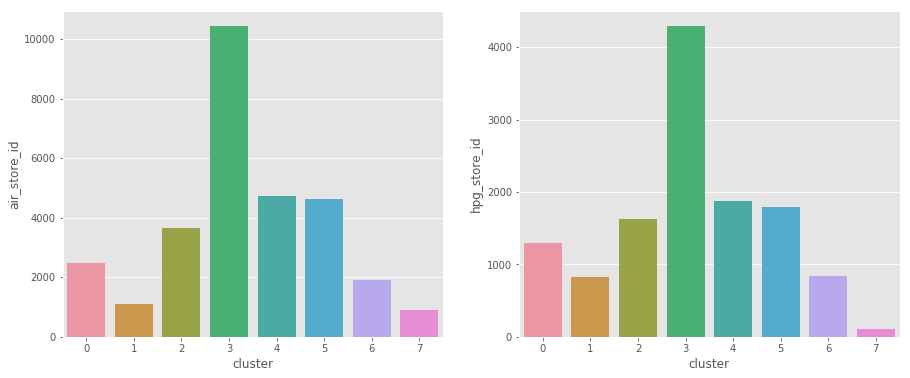

In [134]:
f,axa = plt.subplots(1,2,figsize=(15,6))
hist_clust = full.groupby(['cluster'],as_index=False).count()
sns.barplot(x=hist_clust['cluster'],y=hist_clust['air_store_id'],ax=axa[0])
sns.barplot(x=hist_clust['cluster'],y=hist_clust['hpg_store_id'],ax=axa[1])
plt.show()

On the map we can see by the color of the points that the classes are rightly spread out and distributed around the black points.<br>
Now we check which class number is equal to which region.

In [135]:
#separate the first part of the name of the region
#full['prefecture'] = full['air_area_name'].map(lambda x: str(x).split(' ')[0])
#full.head(1)


#duplTable = full.drop_duplicates()

In [136]:
#duplTable.info()

In [137]:
aircluster = full.groupby(['prefecture','cluster',], as_index=False)['air_store_id'].count()
aircluster['percent'] = aircluster.air_store_id/aircluster.air_store_id.sum()*100
aircluster.head(10)
#we calculate what percentage of all restaurants are in each region

,prefecture,cluster,air_store_id,percent
0,Fukuoka-ken,5,4623,15.497821
1,Hiroshima-ken,0,2470,8.280255
2,Hokkaidō,2,3656,12.256118
3,Hyōgo-ken,4,2583,8.659068
4,Miyagi-ken,7,901,3.020449
5,Niigata-ken,1,1112,3.727791
6,Shizuoka-ken,6,1914,6.416359
7,Tōkyō-to,3,10430,34.964801
8,Ōsaka-fu,4,2141,7.177338


In [138]:
#print(len(aircluster['air_store_id'].unique()))
aircluster.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

Let's try to relate the identified groups with the biggest cities:

* Cluster 0 refers to Hiroshima-ken.
* Cluster 1 refers  to Niigata-ken
* Cluster 2 refers to Hokkaidō
* Cluster 3 refers to Tōkyō-to
* Cluster 4 refers to Hyōgo-ken
* Cluster 5 referst to Fukuoka-ken
* Cluster 6 refers to Shizuoka-ken
* Cluster 7 refers to Miyagi-ken

In [139]:
aircluster.air_store_id.sum()

29830

## Cousine Genres

Now let's check out wht are the genres appreciated in Japan. I have prepared two heatmaps: the former with thenumber of restaurants for each genre (columns) in each region (row) for thos with AIR reservation system; the latter with the HPG.
We are very interested in popularity by region and by genre.<br>
These are the main factors determining the choice!

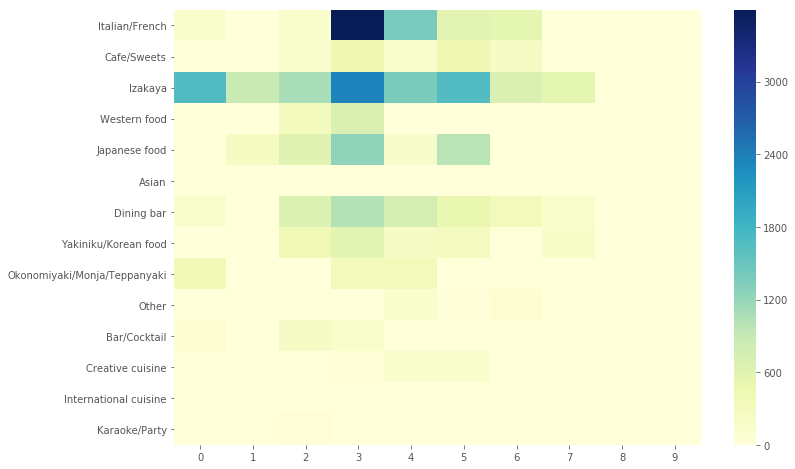

In [140]:
air_genre = full.loc[full.air_genre_name.isnull()==False].groupby(['cluster','air_genre_name'],as_index=False).count()
genres = air.air_genre_name.unique()

#i = 0
fig=plt.figure(figsize=(26,8))
ax2 = fig.add_subplot(122)
hm = []
for i in range(10):
    genres_count = [ air_genre.loc[air_genre.cluster==i].loc[air_genre.air_genre_name==name]['air_store_id'].values[0] if name in air_genre.loc[air_genre.cluster==i].air_genre_name.values else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm,columns=genres,)
sns.heatmap(hm.transpose(),cmap="YlGnBu",ax=ax2)

plt.show()

From the resulting heat map we see that the most popular region is number "3"- Tōkyō-to and genre "Italian\French". <br>
Also we cen see that the in other region the most popula genre is "Izakaya". An izakaya (居酒屋) is a type of informal Japanese pub. They are casual places for after-work drinking. They have been compared to Irish pubs, tapas bars and early American saloons and taverns.

## Japanese Holidays and date conversion

  At the stage ofdata analysis(EDA), we see that one of the important factors affecting the attendance of restaurants are day of the week, month and holidays.

I want to learn more about that so I will rely on this list https://www.officeholidays.com/countries/japan/index.php

* Jan 1st - **New Years day **;
* 2nd Monday of January - **Coming of Age day **: The day honors young Japanese who will reach the age of 20 at any point during the year. Twenty is the age of majority in Japan, and people who have reached this age gain the right to vote in elections as well as to drink;
* Feb 11th - **National Foundation day**:  a national holiday for Japanese people to remind themselves of the nation's founding and foster their love for the nation;
* March 20th or 21st- **Vernal Equinox day**: The day is intended to celebrate the love of nature and living things.In modern Japan, the day still maintains its older traditions as visiting family graves and holding family reunions is a common way of celebrating the equinox;
* April 29th - ** Showa day**: Showa Day honours the birthday of Emperor Hirohito, the reigning Emperor before, during, and after World War II (from 1926 - 1989);

In [141]:
#dates.rename(columns={'calendar_date':'visit_date'})
dates['visit_date']=dates['calendar_date']
dates.head(3)

,calendar_date,day_of_week,holiday_flg,visit_date
0,2016-01-01,Friday,1,2016-01-01
1,2016-01-02,Saturday,1,2016-01-02
2,2016-01-03,Sunday,1,2016-01-03


In [142]:
dates.drop(['calendar_date'], axis=1, inplace=True)

In [143]:
full.head(1)

,air_store_id,visit_date,reserve_visitors,res_date_diff,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_res_date_diff,hpg_genre_name,hpg_area_name,prefecture,cluster
0,air_00a91d42b08b08d9,2016-10-31,2,0.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,hpg_fbe603376b5980fc,NaN,NaN,NaN,Tōkyō-to,3


In [144]:
full.columns

Index(['air_store_id', 'visit_date', 'reserve_visitors', 'res_date_diff',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'hpg_store_id', 'hpg_res_date_diff', 'hpg_genre_name', 'hpg_area_name',
       'prefecture', 'cluster'],
      dtype='object')

In [145]:
full.drop(['hpg_store_id','hpg_res_date_diff','hpg_genre_name','hpg_area_name','air_area_name'], axis=1, inplace=True)

In [146]:
full.columns

Index(['air_store_id', 'visit_date', 'reserve_visitors', 'res_date_diff',
       'air_genre_name', 'latitude', 'longitude', 'prefecture', 'cluster'],
      dtype='object')

In [147]:
full['visit_date'] = pd.to_datetime(full['visit_date'])

In [148]:
full['month'] = full['visit_date'].dt.month 
full['date'] = full['visit_date'].dt.day
full['dw'] = full['visit_date'].dt.dayofweek
full['dy'] = full['visit_date'].dt.dayofyear
full.head()

,air_store_id,visit_date,reserve_visitors,res_date_diff,air_genre_name,latitude,longitude,prefecture,cluster,month,date,dw,dy
0,air_00a91d42b08b08d9,2016-10-31,2,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,10,31,0,305
1,air_00a91d42b08b08d9,2016-12-05,9,4.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,5,0,340
2,air_00a91d42b08b08d9,2016-12-14,18,6.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,14,2,349
3,air_00a91d42b08b08d9,2016-12-17,2,6.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,17,5,352
4,air_00a91d42b08b08d9,2016-12-20,4,2.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,20,1,355


In [149]:
full['visit_date']=full['visit_date']

In [150]:
dates['visit_date'] = pd.to_datetime(dates['visit_date'])
full['visit_date'] = pd.to_datetime(full['visit_date'])

In [151]:
nf = pd.merge(full, dates, how='left', on=['visit_date']) 
#nf = pd.merge(full,dates,on='visit_date', how='outer', validate="many_to_one")
nf.head()
#pd.merge(left, right, on='B', how='outer', validate="one_to_one")

,air_store_id,visit_date,reserve_visitors,res_date_diff,air_genre_name,latitude,longitude,prefecture,cluster,month,date,dw,dy,day_of_week,holiday_flg
0,air_00a91d42b08b08d9,2016-10-31,2,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,10,31,0,305,Monday,0
1,air_00a91d42b08b08d9,2016-12-05,9,4.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,5,0,340,Monday,0
2,air_00a91d42b08b08d9,2016-12-14,18,6.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,14,2,349,Wednesday,0
3,air_00a91d42b08b08d9,2016-12-17,2,6.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,17,5,352,Saturday,0
4,air_00a91d42b08b08d9,2016-12-20,4,2.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,20,1,355,Tuesday,0


In [152]:
nf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29830 entries, 0 to 29829
Data columns (total 15 columns):
air_store_id        29830 non-null object
visit_date          29830 non-null datetime64[ns]
reserve_visitors    29830 non-null int64
res_date_diff       29830 non-null float64
air_genre_name      29830 non-null object
latitude            29830 non-null float64
longitude           29830 non-null float64
prefecture          29830 non-null object
cluster             29830 non-null int32
month               29830 non-null int64
date                29830 non-null int64
dw                  29830 non-null int64
dy                  29830 non-null int64
day_of_week         29830 non-null object
holiday_flg         29830 non-null int64
dtypes: datetime64[ns](1), float64(3), int32(1), int64(6), object(4)
memory usage: 3.5+ MB


In [153]:
full.drop(['visit_date'], axis=1, inplace=True)

In [154]:
#we assign indexes for holiday, sunday, saturday.
nf['sunday'] = nf['visit_date'].dt.dayofweek.apply(lambda x:1 if x==6 else 0)
nf['saturday'] = nf['visit_date'].dt.dayofweek.apply(lambda x:1 if x==5 else 0)
nf['sat/sun/hol']=nf['holiday_flg']*1+nf['sunday']*0.5+nf['saturday']*0.3

nf2016 = nf[nf['visit_date'].dt.year==2016]
nf2017 = nf[nf['visit_date'].dt.year==2017]
nf.head()

,air_store_id,visit_date,reserve_visitors,res_date_diff,air_genre_name,latitude,longitude,prefecture,cluster,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol
0,air_00a91d42b08b08d9,2016-10-31,2,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,10,31,0,305,Monday,0,0,0,0.0
1,air_00a91d42b08b08d9,2016-12-05,9,4.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,5,0,340,Monday,0,0,0,0.0
2,air_00a91d42b08b08d9,2016-12-14,18,6.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,14,2,349,Wednesday,0,0,0,0.0
3,air_00a91d42b08b08d9,2016-12-17,2,6.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,17,5,352,Saturday,0,0,1,0.3
4,air_00a91d42b08b08d9,2016-12-20,4,2.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,12,20,1,355,Tuesday,0,0,0,0.0


We can check how many days before the visit japenese people make the reservation.

In [155]:
nf.res_date_diff.describe()

count    29830.000000
mean         5.598274
std          9.755162
min          0.000000
25%          1.000000
50%          2.500000
75%          7.000000
max        349.500000
Name: res_date_diff, dtype: float64

## Weather Data

In [156]:
wd.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [157]:
#separate the first part of the name of the region
wd['prefecture'] = wd['area_name'].map(lambda x: str(x).split('_')[0])
wd.head(1)

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,prefecture
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1,fukuoka


In [166]:
wdmytest = wd.groupby(['prefecture'], as_index=False)['avg_temperature'].mean()
wdmytest.head(20)

,prefecture,avg_temperature
0,fukuoka,15.728844
1,hiroshima,14.317344
2,hokkaido,5.872029
3,hyogo,14.592747
4,kanagawa,15.356673
5,miyagi,11.087105
6,niigata,12.433745
7,osaka,14.812773
8,saitama,13.533269
9,shizuoka,15.470068


Let's try to relate the identified groups with the biggest cities:

* Cluster 0 refers to Hiroshima-ken.+
* Cluster 1 refers  to Niigata-ken+
* Cluster 2 refers to Hokkaidō+
* Cluster 3 refers to Tōkyō-to+
* Cluster 4 refers to Hyōgo-ken
* Cluster 5 referst to Fukuoka-ken+
* Cluster 6 refers to Shizuoka-ken+
* Cluster 7 refers to Miyagi-ken+

In [167]:
import re
def area2group(area):
    if re.match(r'tokyo.*',area) !=None:
        return 3
    if re.match(r'hyogo.*',area) !=None:
        return 4
    if re.match(r'hokkaido.*',area) !=None:
        return 2    
    if re.match(r'fukuoka.*',area) !=None:
        return 5
    if re.match(r'niigata.*',area) !=None:
        return 1
    if re.match(r'hiroshima.*',area) !=None:
        return 0
    if re.match(r'shizuoka.*',area) !=None:
        return 6
    if re.match(r'miyagi.*',area) !=None:
        return 7
    else:
        return -1

warea = [area2group(area) for area in wd.area_name]
wd['cluster'] = warea
#re.match(r'fukuoka.*',wd.area_name[0])
#wd.area_name

In [168]:
wd['calendar_date'] = pd.to_datetime(wd.calendar_date).dt.date

In [169]:
wdg = wd.groupby(['cluster','calendar_date'],as_index=False).mean()
wdg.head(1)

,cluster,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,-1,2016-01-01,0.0,6.36,NaN,NaN,8.4125,2.09,5.966667,55.333333,1028.5,1022.5,11.215,2.833333,11.13,2.35


In [170]:
airvisit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [171]:
nf['visit_date']=pd.to_datetime(nf.visit_date).dt.date
nf.head(1)

,air_store_id,visit_date,reserve_visitors,res_date_diff,air_genre_name,latitude,longitude,prefecture,cluster,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol
0,air_00a91d42b08b08d9,2016-10-31,2,0.0,Italian/French,35.694003,139.753595,Tōkyō-to,3,10,31,0,305,Monday,0,0,0,0.0


In [172]:
wnf = pd.merge(wdg,nf,left_on=['cluster','calendar_date'],right_on=['cluster','visit_date'])
wnf.tail()

,cluster,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,...,prefecture,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol
29825,7,2017-05-13,61.666667,12.933333,0.0,0.0,0.000000,3.966667,14.5,95.0,...,Miyagi-ken,5,13,5,133,Saturday,0,0,1,0.3
29826,7,2017-05-13,61.666667,12.933333,0.0,0.0,0.000000,3.966667,14.5,95.0,...,Miyagi-ken,5,13,5,133,Saturday,0,0,1,0.3
29827,7,2017-05-15,12.166667,13.066667,0.0,0.0,0.000000,1.600000,14.6,95.0,...,Miyagi-ken,5,15,0,135,Monday,0,0,0,0.0
29828,7,2017-05-20,0.000000,20.166667,0.0,0.0,13.466667,2.300000,12.7,56.0,...,Miyagi-ken,5,20,5,140,Saturday,0,0,1,0.3
29829,7,2017-05-23,0.000000,18.166667,0.0,0.0,5.666667,2.233333,16.8,79.0,...,Miyagi-ken,5,23,1,143,Tuesday,0,0,0,0.0


In [173]:
#wnf['']

In [174]:
airvisit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [175]:
airvisit['visit_date'] = pd.to_datetime(airvisit['visit_date']).dt.date
wnf = pd.merge(wnf,airvisit,on=['air_store_id','visit_date'])

In [176]:
wnf.head()

,cluster,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,...,month,date,dw,dy,day_of_week,holiday_flg,sunday,saturday,sat/sun/hol,visitors
0,0,2016-01-02,0.0,6.800000,NaN,NaN,3.733333,1.666667,8.10,77.5,...,1,2,5,2,Saturday,1,0,1,1.3,28
1,0,2016-01-03,0.0,8.733333,NaN,NaN,6.133333,1.633333,9.85,82.5,...,1,3,6,3,Sunday,1,1,0,1.5,29
2,0,2016-01-04,0.0,9.100000,NaN,NaN,6.600000,1.900000,9.15,74.5,...,1,4,0,4,Monday,0,0,0,0.0,17
3,0,2016-01-06,0.0,6.533333,NaN,NaN,0.933333,1.433333,7.90,76.5,...,1,6,2,6,Wednesday,0,0,0,0.0,23
4,0,2016-01-07,0.0,6.433333,NaN,NaN,5.266667,2.100000,6.20,61.0,...,1,7,3,7,Thursday,0,0,0,0.0,37


In [177]:
len(wnf['air_store_id'].unique())

312

### Missing values

In [178]:
wnf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28064 entries, 0 to 28063
Data columns (total 34 columns):
cluster               28064 non-null int64
calendar_date         28064 non-null object
precipitation         28064 non-null float64
avg_temperature       28064 non-null float64
total_snowfall        5297 non-null float64
deepest_snowfall      5479 non-null float64
hours_sunlight        28064 non-null float64
avg_wind_speed        28064 non-null float64
avg_vapor_pressure    28054 non-null float64
avg_humidity          28054 non-null float64
avg_sea_pressure      28064 non-null float64
avg_local_pressure    28064 non-null float64
solar_radiation       23610 non-null float64
cloud_cover           28064 non-null float64
high_temperature      28064 non-null float64
low_temperature       28064 non-null float64
air_store_id          28064 non-null object
visit_date            28064 non-null object
reserve_visitors      28064 non-null int64
res_date_diff         28064 non-null float64


We can see that there are two columns in which there are zero values: "Total snowfall" and "Deepest snowfall".
It's snowing in japan only in winter.This is less than half of our data.We also make a forecast for the spring.

We decided to delete the following columns

## Variable selection

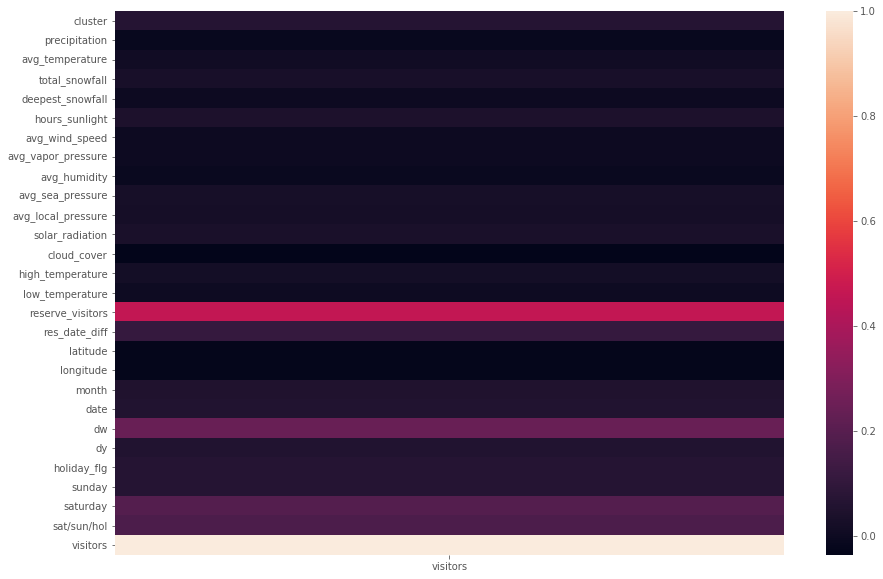

In [179]:
f,axa = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(wnf.corr()[['visitors']])

Apparently there number of visitors is not correlated with the weather conditions

In [89]:
def our_hat_code(myData, colQuery):
    temp = list(myData[colQuery].unique())
    print(temp)
    n = len(temp) 
    print(n)
    for ii in range(0,n):
        #print('test')
        #print("1",myData[ii])
        #print("2",myData[temp[ii]])
        myData[temp[ii]] = None
        myData.loc[(myData[colQuery] == temp[ii] ),temp[ii]] = 1
        myData.loc[(myData[colQuery] != temp[ii]),temp[ii]] = 0
        

In [90]:
copyTest = wnf.copy()
#copyTest
#wnf.info()

In [91]:
our_hat_code(copyTest,'air_genre_name')

['Okonomiyaki/Monja/Teppanyaki', 'Izakaya', 'Dining bar', 'Japanese food', 'Bar/Cocktail', 'Italian/French', 'Yakiniku/Korean food', 'Western food', 'Cafe/Sweets', 'Karaoke/Party', 'Creative cuisine', 'International cuisine', 'Asian', 'Other']
14


In [92]:
copyTest

,cluster,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,...,Bar/Cocktail,Italian/French,Yakiniku/Korean food,Western food,Cafe/Sweets,Karaoke/Party,Creative cuisine,International cuisine,Asian,Other
0,0,2016-01-02,0.000000,6.800000,NaN,NaN,3.733333,1.666667,8.10,77.5,...,0,0,0,0,0,0,0,0,0,0
1,0,2016-01-03,0.000000,8.733333,NaN,NaN,6.133333,1.633333,9.85,82.5,...,0,0,0,0,0,0,0,0,0,0
2,0,2016-01-04,0.000000,9.100000,NaN,NaN,6.600000,1.900000,9.15,74.5,...,0,0,0,0,0,0,0,0,0,0
3,0,2016-01-06,0.000000,6.533333,NaN,NaN,0.933333,1.433333,7.90,76.5,...,0,0,0,0,0,0,0,0,0,0
4,0,2016-01-07,0.000000,6.433333,NaN,NaN,5.266667,2.100000,6.20,61.0,...,0,0,0,0,0,0,0,0,0,0
5,0,2016-01-07,0.000000,6.433333,NaN,NaN,5.266667,2.100000,6.20,61.0,...,0,0,0,0,0,0,0,0,0,0
6,0,2016-01-07,0.000000,6.433333,NaN,NaN,5.266667,2.100000,6.20,61.0,...,0,0,0,0,0,0,0,0,0,0
7,0,2016-01-08,0.000000,5.266667,NaN,NaN,0.566667,2.466667,5.90,62.0,...,0,0,0,0,0,0,0,0,0,0
8,0,2016-01-08,0.000000,5.266667,NaN,NaN,0.566667,2.466667,5.90,62.0,...,0,0,0,0,0,0,0,0,0,0
9,0,2016-01-08,0.000000,5.266667,NaN,NaN,0.566667,2.466667,5.90,62.0,...,0,0,0,0,0,0,0,0,0,0


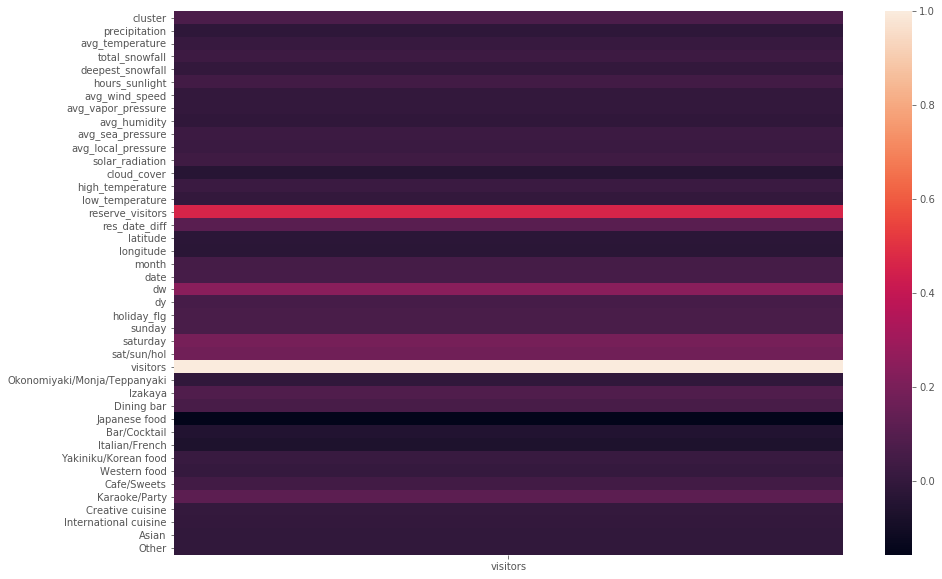

In [93]:
f,axa = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(copyTest.corr()[['visitors']])

In [94]:
copyTest['cluster'] = copyTest['cluster'].astype('category')

In [95]:
copyTest.describe()

,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,...,Bar/Cocktail,Italian/French,Yakiniku/Korean food,Western food,Cafe/Sweets,Karaoke/Party,Creative cuisine,International cuisine,Asian,Other
count,28064.000000,28064.000000,5297.000000,5479.000000,28064.000000,28064.000000,28054.000000,28054.000000,28064.000000,28064.000000,...,28064.000000,28064.000000,28064.000000,28064.000000,28064.000000,28064.000000,28064.000000,28064.000000,28064.000000,28064.000000
mean,3.083158,8.198047,2.121862,21.558381,5.412953,2.751646,7.999076,65.683592,1016.891317,1013.005105,...,0.015180,0.216327,0.053734,0.033851,0.045966,0.001532,0.011794,0.000107,0.000036,0.008837
std,7.990080,6.112476,3.481494,23.550224,3.557553,0.996354,4.262752,13.686112,6.972326,7.357350,...,0.122269,0.411747,0.225497,0.180849,0.209416,0.039114,0.107962,0.010339,0.005969,0.093590
min,0.000000,-13.071429,0.000000,0.000000,0.000000,0.733333,2.000000,28.000000,992.700000,985.175000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.975000,0.000000,0.000000,2.133333,2.028571,5.100000,56.500000,1012.400000,1008.425000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.055556,7.814286,0.500000,8.833333,5.700000,2.571429,6.800000,66.000000,1017.500000,1013.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.800000,11.971429,3.142857,48.142857,8.483333,3.262500,9.650000,75.000000,1022.050000,1018.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,138.687500,31.585714,32.250000,73.714286,13.366667,7.850000,32.200000,99.000000,1035.400000,1031.600000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [96]:
copyTest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28064 entries, 0 to 28063
Data columns (total 48 columns):
cluster                         28064 non-null category
calendar_date                   28064 non-null object
precipitation                   28064 non-null float64
avg_temperature                 28064 non-null float64
total_snowfall                  5297 non-null float64
deepest_snowfall                5479 non-null float64
hours_sunlight                  28064 non-null float64
avg_wind_speed                  28064 non-null float64
avg_vapor_pressure              28054 non-null float64
avg_humidity                    28054 non-null float64
avg_sea_pressure                28064 non-null float64
avg_local_pressure              28064 non-null float64
solar_radiation                 23610 non-null float64
cloud_cover                     28064 non-null float64
high_temperature                28064 non-null float64
low_temperature                 28064 non-null float64
air_store_id 

In [97]:
our_hat_code(copyTest,'cluster')

[0, 1, 2, 3, 4, 5, 6, 7]
8


In [98]:
copyTest.head(1)

,cluster,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,...,Asian,Other,0,1,2,3,4,5,6,7
0,0,2016-01-02,0.0,6.8,NaN,NaN,3.733333,1.666667,8.1,77.5,...,0,0,1,0,0,0,0,0,0,0


In [99]:
copyTest.columns

Index([                     'cluster',                'calendar_date',
                      'precipitation',              'avg_temperature',
                     'total_snowfall',             'deepest_snowfall',
                     'hours_sunlight',               'avg_wind_speed',
                 'avg_vapor_pressure',                 'avg_humidity',
                   'avg_sea_pressure',           'avg_local_pressure',
                    'solar_radiation',                  'cloud_cover',
                   'high_temperature',              'low_temperature',
                       'air_store_id',                   'visit_date',
                   'reserve_visitors',                'res_date_diff',
                     'air_genre_name',                     'latitude',
                          'longitude',                   'prefecture',
                              'month',                         'date',
                                 'dw',                           'dy',
      

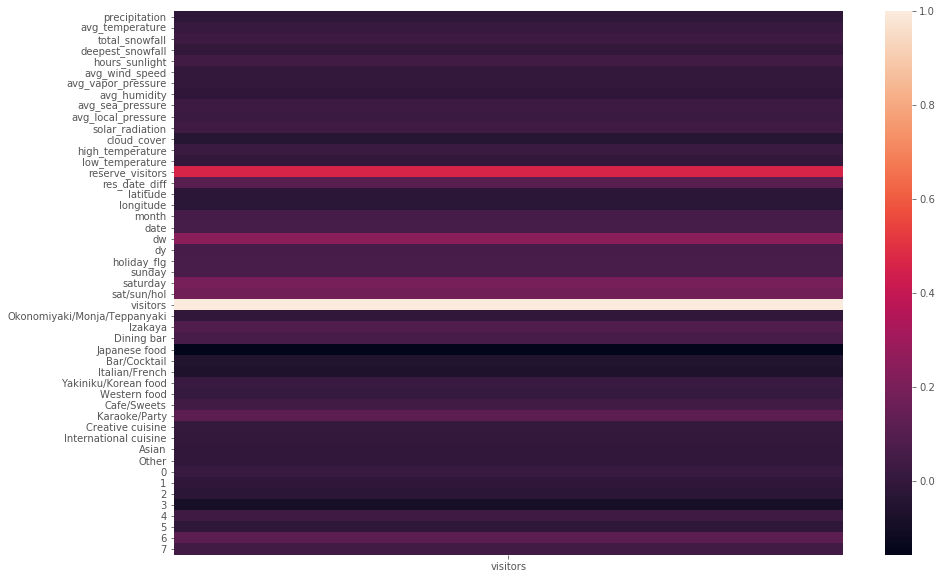

In [100]:
f,axa = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(copyTest.corr()[['visitors']])

In [ ]:
#